In [2]:
#Data Manipulation
import pandas as pd
import numpy as np

# Machine learning (preprocessing, models, evaluation)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.metrics import classification_report

# Graphics
from tqdm import tqdm

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

In [3]:
#Read in 2018 data
df = pd.read_csv('Data_2/2018_Financial_Data.csv')

In [4]:
#Rename Ticker column
df = df.rename(columns={'Unnamed: 0': 'Ticker'})
df.head()

,Ticker,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2019 PRICE VAR [%],Class
0,CMCSA,9.450700e+10,0.1115,0.000000e+00,9.450700e+10,0.000000e+00,6.482200e+10,7.549800e+10,1.900900e+10,3.542000e+09,...,0.2570,0.0000,0.3426,0.0722,0.7309,0.0000,0.1308,Consumer Cyclical,32.794573,1
1,KMI,1.414400e+10,0.0320,7.288000e+09,6.856000e+09,0.000000e+00,6.010000e+08,3.062000e+09,3.794000e+09,1.917000e+09,...,0.0345,-0.0920,-0.0024,0.0076,-0.0137,0.0000,-0.1265,Energy,40.588068,1
2,INTC,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,...,0.1989,0.0387,0.0382,0.1014,-0.0169,0.0390,-0.0942,Technology,30.295514,1
3,MU,3.039100e+10,0.4955,1.250000e+10,1.789100e+10,2.141000e+09,8.130000e+08,2.897000e+09,1.499400e+10,3.420000e+08,...,0.4573,0.1511,0.2275,0.6395,-0.5841,0.1738,0.0942,Technology,64.213737,1
4,GE,1.216150e+11,0.0285,9.546100e+10,2.615400e+10,0.000000e+00,1.811100e+10,4.071100e+10,-1.455700e+10,5.059000e+09,...,-0.2781,-0.2892,-0.1575,-0.4487,-0.2297,0.0000,0.0308,Industrials,44.757840,1


# Visualizing Sector Price Performance

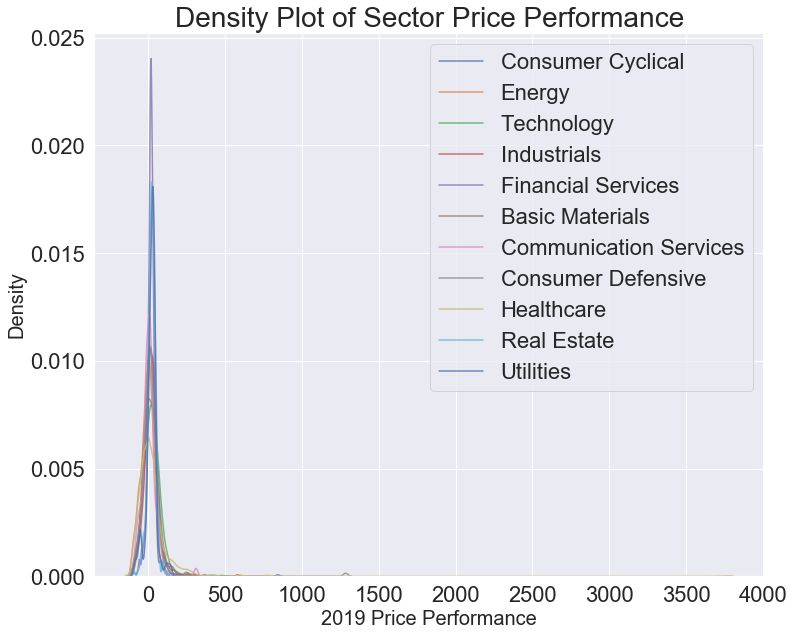

In [5]:
# Plot of distribution of price performance for sectors
figsize(12, 10)

# Plot each stock
for sec in df['Sector'].unique():
    # Select the sector
    subset = df[df['Sector'] == sec]
    
    # Density plot of price performance
    sns.kdeplot(subset['2019 PRICE VAR [%]'].dropna(),
               label = sec, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('2019 Price Performance', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Sector Price Performance', size = 28);
plt.savefig('images\Fig5_den_vs_price.png')

In [6]:
#This is super skewed so I want to exclude outliers just to look at the relative distribution
# Calculate first and third quartile
first_quartile = df['2019 PRICE VAR [%]'].describe()['25%']
third_quartile = df['2019 PRICE VAR [%]'].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
df_cut = df[(df['2019 PRICE VAR [%]'] > (first_quartile - 3 * iqr)) &
            (df['2019 PRICE VAR [%]'] < (third_quartile + 3 * iqr))]

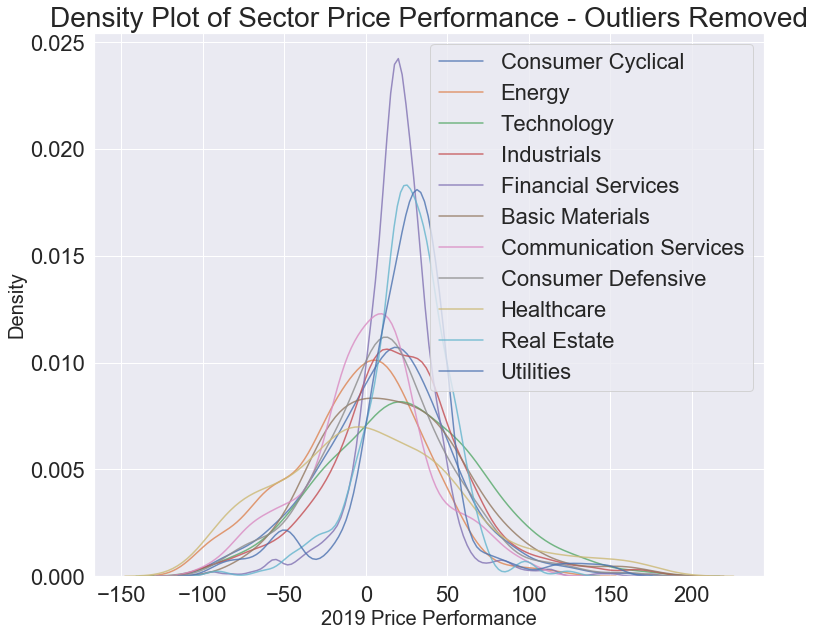

In [7]:
# Plot of distribution of price performance for sectors
figsize(12, 10)

# Plot each stock
for sec in df_cut['Sector'].unique():
    # Select the sector
    subset = df_cut[df_cut['Sector'] == sec]
    
    # Density plot of price performance
    sns.kdeplot(subset['2019 PRICE VAR [%]'].dropna(),
               label = sec, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('2019 Price Performance', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Sector Price Performance - Outliers Removed', size = 28);
plt.savefig('images\Fig6_den_vs_price-outliers.png')

# Dividing Dataframe into Sector-Specific Datafames

Now that I looked at the data broadly, I would like to split the dataframe into sector-specific variables in order to train the ML models uniquely. Operational growth, spend, and margin disparity is huge amongst the various sectors so they should not be trained in aggregate because there are specific industry variables that the model should fit more tightly to.

In [102]:
#Find Sector names
df.Sector.unique()

array(['Consumer Cyclical', 'Energy', 'Technology', 'Industrials',
       'Financial Services', 'Basic Materials', 'Communication Services',
       'Consumer Defensive', 'Healthcare', 'Real Estate', 'Utilities'],
      dtype=object)

In [103]:
#Make Sector specific dataframes
df_cc = df[df['Sector'] == 'Consumer Cyclical'].set_index(['Ticker', 'Sector'])
df_energy = df[df['Sector'] == 'Energy'].set_index(['Ticker', 'Sector'])
df_tech = df[df['Sector'] == 'Technology'].set_index(['Ticker', 'Sector'])
df_ind = df[df['Sector'] == 'Industrials'].set_index(['Ticker', 'Sector'])
df_fin = df[df['Sector'] == 'Financial Services'].set_index(['Ticker', 'Sector'])
df_bm = df[df['Sector'] == 'Basic Materials'].set_index(['Ticker', 'Sector'])
df_comm = df[df['Sector'] == 'Communication Services'].set_index(['Ticker', 'Sector'])
df_cdef = df[df['Sector'] == 'Consumer Defensive'].set_index(['Ticker', 'Sector'])
df_health = df[df['Sector'] == 'Healthcare'].set_index(['Ticker', 'Sector'])
df_re = df[df['Sector'] == 'Real Estate'].set_index(['Ticker', 'Sector'])
df_util = df[df['Sector'] == 'Utilities'].set_index(['Ticker', 'Sector'])


In [104]:
#Check tech dataframe
df_tech.head()

,,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,2019 PRICE VAR [%],Class
Ticker,Sector,,,,,,,,,,,,,,,,,,,,,
INTC,Technology,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,2.331700e+10,...,0.0772,0.1989,0.0387,0.0382,0.1014,-0.0169,0.0390,-0.0942,30.295514,1
MU,Technology,3.039100e+10,0.4955,1.250000e+10,1.789100e+10,2.141000e+09,8.130000e+08,2.897000e+09,1.499400e+10,3.420000e+08,1.430300e+10,...,0.0000,0.4573,0.1511,0.2275,0.6395,-0.5841,0.1738,0.0942,64.213737,1
AAPL,Technology,2.655950e+11,0.1586,1.637560e+11,1.018390e+11,1.423600e+10,1.670500e+10,3.094100e+10,7.089800e+10,0.000000e+00,7.290300e+10,...,0.1116,0.3734,-0.1852,-0.0256,-0.1584,-0.0103,0.2293,0.0946,88.742465,1
MSFT,Technology,1.103600e+11,0.1428,3.835300e+10,7.200700e+10,1.472600e+10,2.222300e+10,3.694900e+10,3.505800e+10,0.000000e+00,3.647400e+10,...,0.1089,0.1806,0.2205,0.0341,-0.0512,-0.1066,0.1296,0.1144,58.259263,1
HPQ,Technology,5.847200e+10,0.1233,4.780300e+10,1.066900e+10,1.404000e+09,4.859000e+09,6.605000e+09,4.064000e+09,1.051000e+09,3.013000e+09,...,-0.0606,0.1584,0.0477,0.0519,0.8039,-0.2343,0.1798,0.1104,3.016789,1


In [105]:
df_tech.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 636 entries, (INTC, Technology) to (WTT, Technology)
Columns: 223 entries, Revenue to Class
dtypes: float64(222), int64(1)
memory usage: 1.1+ MB


# Remove Columns with Many Missing Values

In [106]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df_tech.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df_tech.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [107]:
#Visualize the % of missing values in the tech data set
missing_values_table(df_tech)

Your selected dataframe has 223 columns.
There are 194 columns that have missing values.


,Missing Values,% of Total Values
operatingCycle,636,100.0
cashConversionCycle,636,100.0
shortTermCoverageRatios,282,44.3
dividendPayoutRatio,275,43.2
priceEarningsToGrowthRatio,275,43.2
niperEBT,265,41.7
nIperEBT,265,41.7
effectiveTaxRate,265,41.7
ebtperEBIT,249,39.2
eBTperEBIT,249,39.2


In [108]:
# Get the columns with > 50% missing
missing_df = missing_values_table(df_tech);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('We will remove %d columns.' % len(missing_columns))

Your selected dataframe has 223 columns.
There are 194 columns that have missing values.
We will remove 2 columns.


In [109]:
# Drop the columns
df_tech1 = df_tech.drop(columns = list(missing_columns))

In [1]:
figsize(8, 8)

# Histogram of the tech price performance
plt.style.use('fivethirtyeight')
plt.hist(df_tech_clean['2019 PRICE VAR [%]'].dropna(), bins = 50, edgecolor = 'k');
plt.xlabel('2019 Price Performance'); plt.ylabel('Number of Equity Securities'); 
plt.title('2019 Equity Performance Distribution');
plt.savefig('images\Fig5.png')

NameError: name 'figsize' is not defined

# Correlation between Features and Target

In [111]:
# Find all correlations and sort 
correlations_tech = df_tech1.corr()['2019 PRICE VAR [%]'].sort_values()

# Print the most negative correlations
print(correlations_tech.head(15), '\n')

# Print the most positive correlations
print(correlations_tech.tail(15))

priceEarningsToGrowthRatio               -0.115496
Weighted Average Shares Diluted Growth   -0.088631
Capex to Depreciation                    -0.082627
Weighted Average Shares Growth           -0.081421
fixedAssetTurnover                       -0.069654
EV to Free cash flow                     -0.062445
Graham Net-Net                           -0.060094
payablesTurnover                         -0.058747
Payables Turnover                        -0.058747
cashRatio                                -0.054737
Debt Growth                              -0.049879
Operating Cash Flow growth               -0.047212
Dividend Yield                           -0.046711
Dividend payments                        -0.046527
Free Cash Flow per Share                 -0.046340
Name: 2019 PRICE VAR [%], dtype: float64 

5Y Shareholders Equity Growth (per Share)    0.089835
companyEquityMultiplier                      0.105217
PB ratio                                     0.105250
priceBookValueRatio           

##### To account for possible non-linear relationships, I now take the square root and natural log transformations of the features and then calculate the correlation coefficients with the 2019 price performance.

In [112]:
# Create columns with square root and log of numeric columns
for col in df_tech1.columns:
    # Skip the Price Var column
    if col == '2019 PRICE VAR [%]' or col == 'Class':
        next
    else:
        df_tech1['sqrt_' + col] = np.sqrt(df_tech_clean[col])
        df_tech1['log_' + col] = np.log(df_tech_clean[col])

# Drop stocks without 2019 price performance
df_tech2 = df_tech1.dropna(subset = ['2019 PRICE VAR [%]'])

# Find correlations with the price performance 
correlations = df_tech2.corr()['2019 PRICE VAR [%]'].dropna().sort_values()

C:\Users\hchapman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\Users\hchapman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\hchapman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


In [113]:
# Display most negative correlations
correlations.head(15)

sqrt_Capex to Depreciation                    -0.316530
sqrt_Capital Expenditure                      -0.256221
sqrt_Capex per Share                          -0.208572
log_Preferred Dividends                       -0.164031
log_SG&A to Revenue                           -0.145818
sqrt_priceEarningsToGrowthRatio               -0.142865
log_Debt Growth                               -0.128889
log_Net Cash/Marketcap                        -0.128010
priceEarningsToGrowthRatio                    -0.115496
log_Graham Net-Net                            -0.111960
sqrt_Graham Net-Net                           -0.110717
sqrt_Weighted Average Shares Diluted Growth   -0.109237
sqrt_Net Cash/Marketcap                       -0.109155
sqrt_fixedAssetTurnover                       -0.106659
log_Net Income - Discontinued ops             -0.100553
Name: 2019 PRICE VAR [%], dtype: float64

In [114]:
# Display most positive correlations
correlations.tail(15)

log_Total debt                        0.194305
log_Cash and cash equivalents         0.194317
log_Tangible Asset Value              0.194461
log_priceFairValue                    0.199576
log_Consolidated Income               0.202349
log_Average Inventory                 0.205378
log_Weighted Average Shs Out          0.207153
log_Weighted Average Shs Out (Dil)    0.208671
log_Net Debt                          0.211052
log_Deposit Liabilities               0.220582
log_Investing Cash flow               0.261254
log_Capex per Share                   0.389897
log_Capital Expenditure               0.450411
Class                                 0.641216
2019 PRICE VAR [%]                    1.000000
Name: 2019 PRICE VAR [%], dtype: float64

In [115]:
# Copy the original data
df_tech3 = df_tech2.copy()

df_tech3.shape

(636, 659)

# Remove Collinear Features

In [116]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    
    # Dont want to remove correlations between Energy Star Score
    y = x['2019 PRICE VAR [%]']
    x = x.drop(columns = ['2019 PRICE VAR [%]'])
    
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    
    # Add the score back in to the data
    x['2019 PRICE VAR [%]'] = y
               
    return x

In [117]:
# Remove the collinear features above a specified correlation coefficient
df_tech4 = remove_collinear_features(df_tech3, 0.6);

C:\Users\hchapman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal


In [118]:
# Remove any columns with all na values
df_tech5  = df_tech4.dropna(axis=1, how = 'all')
df_tech5.head()

,,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,log_Asset Growth,sqrt_Book Value per Share Growth,log_Book Value per Share Growth,sqrt_Debt Growth,log_Debt Growth,sqrt_R&D Expense Growth,log_R&D Expense Growth,sqrt_SG&A Expenses Growth,log_SG&A Expenses Growth,2019 PRICE VAR [%]
Ticker,Sector,,,,,,,,,,,,,,,,,,,,,
INTC,Technology,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,2.331700e+10,...,-3.264920,0.318434,-2.288682,NaN,NaN,0.197484,-3.244194,NaN,NaN,30.295514
MU,Technology,3.039100e+10,0.4955,1.250000e+10,1.789100e+10,2.141000e+09,8.130000e+08,2.897000e+09,1.499400e+10,3.420000e+08,1.430300e+10,...,-1.480605,0.799687,-0.447069,NaN,NaN,0.416893,-1.749850,0.306920,-2.362335,64.213737
AAPL,Technology,2.655950e+11,0.1586,1.637560e+11,1.018390e+11,1.423600e+10,1.670500e+10,3.094100e+10,7.089800e+10,0.000000e+00,7.290300e+10,...,NaN,NaN,NaN,NaN,NaN,0.478853,-1.472724,0.307571,-2.358098,88.742465
MSFT,Technology,1.103600e+11,0.1428,3.835300e+10,7.200700e+10,1.472600e+10,2.222300e+10,3.694900e+10,3.505800e+10,0.000000e+00,3.647400e+10,...,-3.378458,NaN,NaN,NaN,NaN,0.360000,-2.043302,0.338231,-2.168054,58.259263
HPQ,Technology,5.847200e+10,0.1233,4.780300e+10,1.066900e+10,1.404000e+09,4.859000e+09,6.605000e+09,4.064000e+09,1.051000e+09,3.013000e+09,...,-2.958436,0.896605,-0.218280,NaN,NaN,0.424028,-1.715910,0.332265,-2.203645,3.016789


None of the features were exceptionally collinear, so none were removed.

# Split Into Training and Testing Sets

### For 2019 Variance Target (Not Class)

In [138]:
#For 2019 Variance Target
# Separate out the features and targets
features_var = df_tech5.drop(columns=['2019 PRICE VAR [%]', 'Class'], axis=1)
targets_var = pd.DataFrame(df_tech5['2019 PRICE VAR [%]'])

# Replace the inf and -inf with nan (required for later imputation)
features_var = features_var.replace({np.inf: np.nan, -np.inf: np.nan})

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(features_var, targets_var, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(445, 657)
(191, 657)
(445, 1)
(191, 1)


# Establish a Baseline

In [139]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [140]:
baseline_guess = np.median(y)

print('The baseline guess is a price performance of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a price performance of 24.45
Baseline Performance on the test set: MAE = 43.3045


This baseline shows that the average estimate of the test set is off by ~43%. In other words, to add value we need to have a MAE of <43%

In [141]:
# Save the no scores, training, and testing data
X.to_csv('data/training_features.csv', index = False)
X_test.to_csv('data/testing_features.csv', index = False)
y.to_csv('data/training_labels.csv', index = False)
y_test.to_csv('data/testing_labels.csv', index = False)

### For 2019 Class Target (Not % Variance)

In [142]:
#For 2019 Class Target
# Separate out the features and targets
features_class = df_tech5.drop(columns=['2019 PRICE VAR [%]', 'Class'], axis=1)
targets_class = pd.DataFrame(df_tech5['Class'])

# Replace the inf and -inf with nan (required for later imputation)
features_class = features_class.replace({np.inf: np.nan, -np.inf: np.nan})

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(features_class, targets_class, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(445, 657)
(191, 657)
(445, 1)
(191, 1)


In [143]:
baseline_guess = np.median(y)

print('The baseline guess is a class of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a class of 1.00
Baseline Performance on the test set: MAE = 0.2932


In [144]:
# Save the no scores, training, and testing data
X.to_csv('data/training_features2.csv', index = False)
X_test.to_csv('data/testing_features2.csv', index = False)
y.to_csv('data/training_labels2.csv', index = False)
y_test.to_csv('data/testing_labels2.csv', index = False)